In [1]:
from matplotlib import pyplot as plt 
from lines_generator import *
from hough import *
import numpy as np
import cv2
#import keras

## Lines Generator

In [2]:
%%time
lines,ims = im_generator(50)

/home/cordeiro/MEGA/EngdeComputacao/Pic/hough/lines_generator.py:137: RuntimeWarning: divide by zero encountered in true_divide
  angles = np.arctan((ys[:-1]-ys[1:])/(xs[1:]-xs[:-1]))


CPU times: user 11.8 s, sys: 1.28 s, total: 13.1 s
Wall time: 13.2 s


## Binary Images

In [3]:
%%time
#Threshold
#ims_bin = [(im>230)*255 for im in ims]
ims_bin = [bin_im2(im) for im in ims]
ims_bin = np.array(ims_bin)

CPU times: user 2.86 s, sys: 71.6 ms, total: 2.94 s
Wall time: 2.83 s


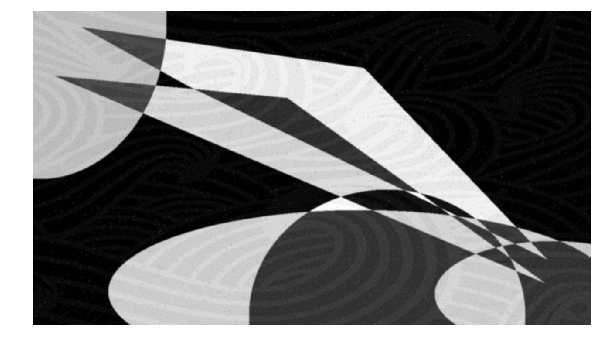

In [4]:
imshow(ims[0])

## Show

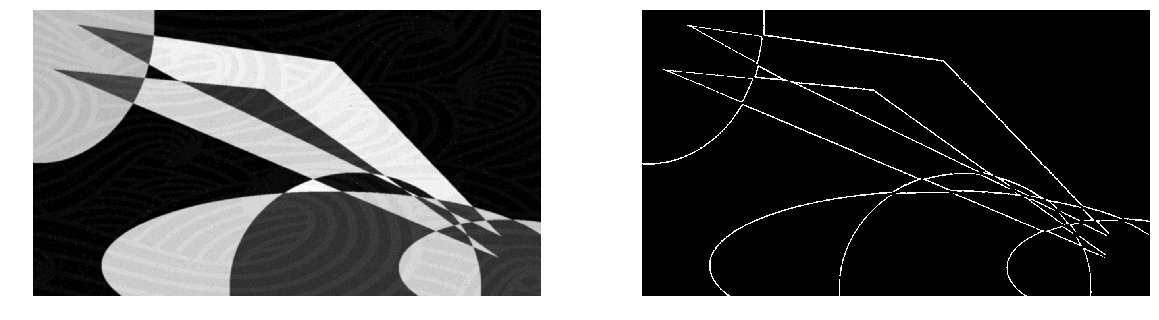

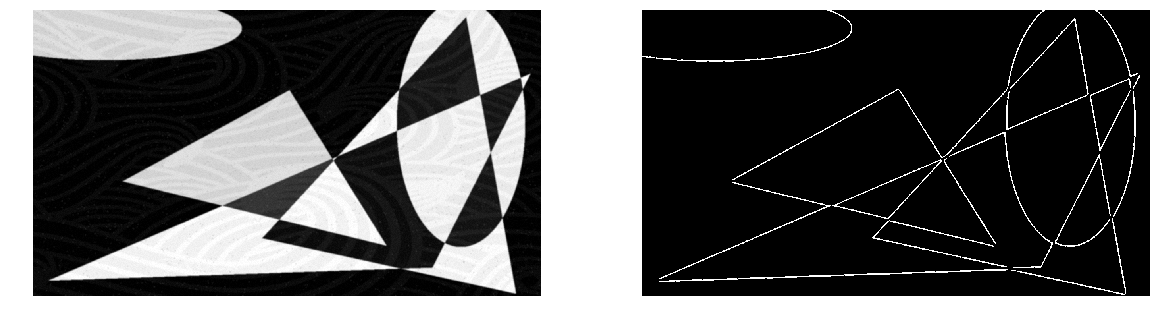

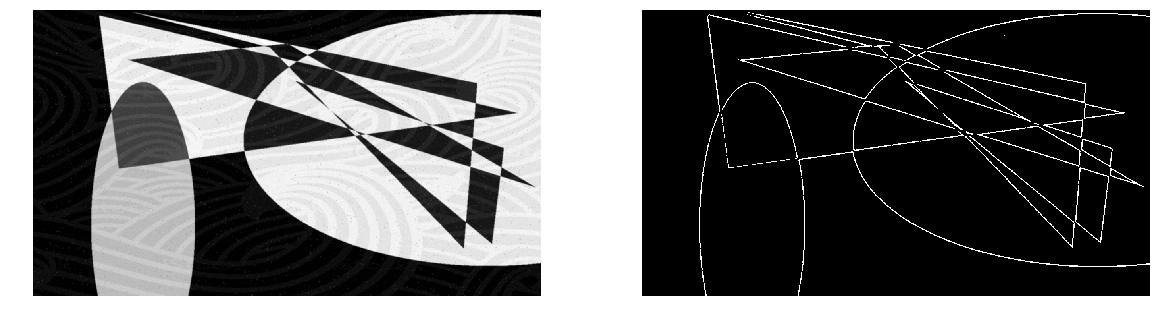

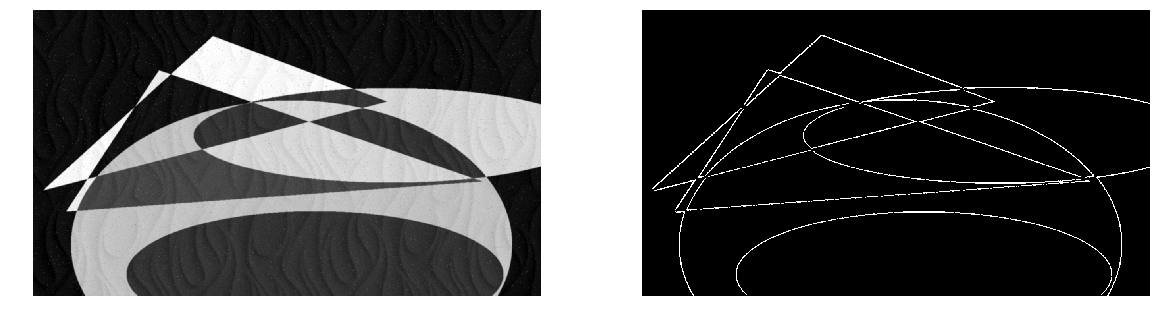

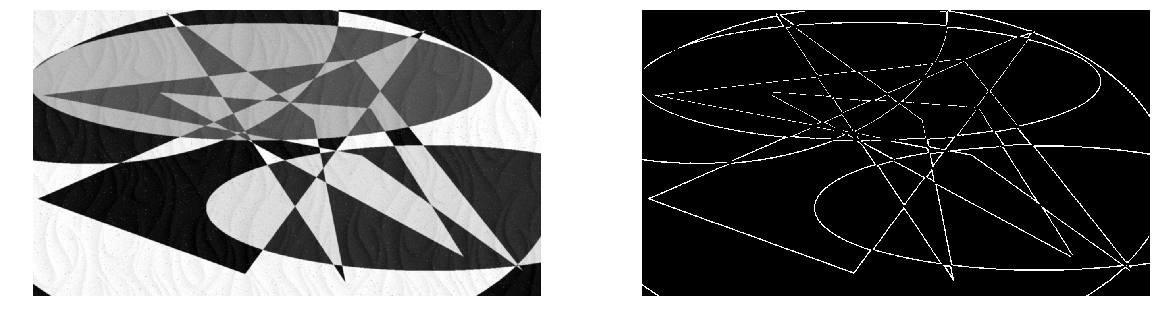

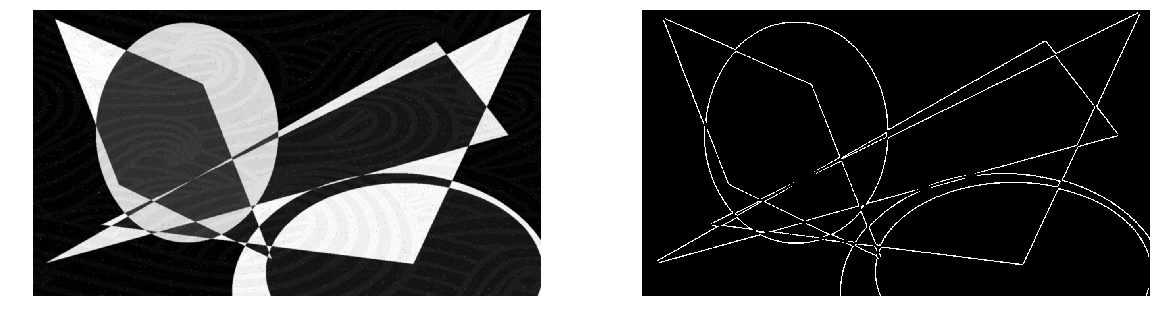

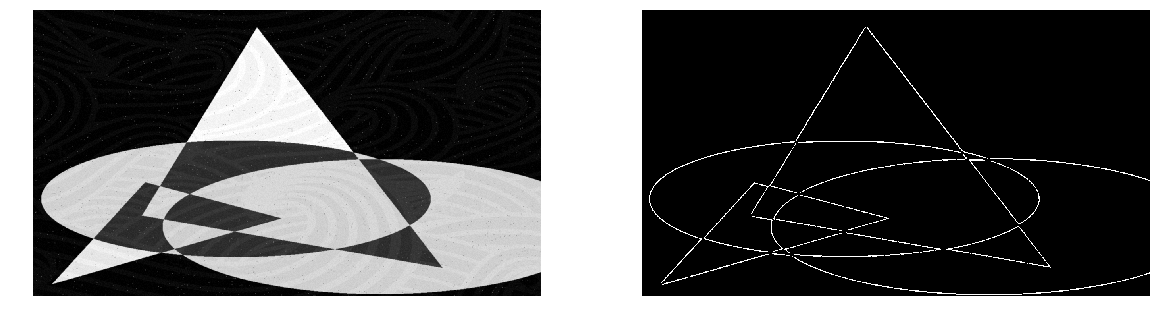

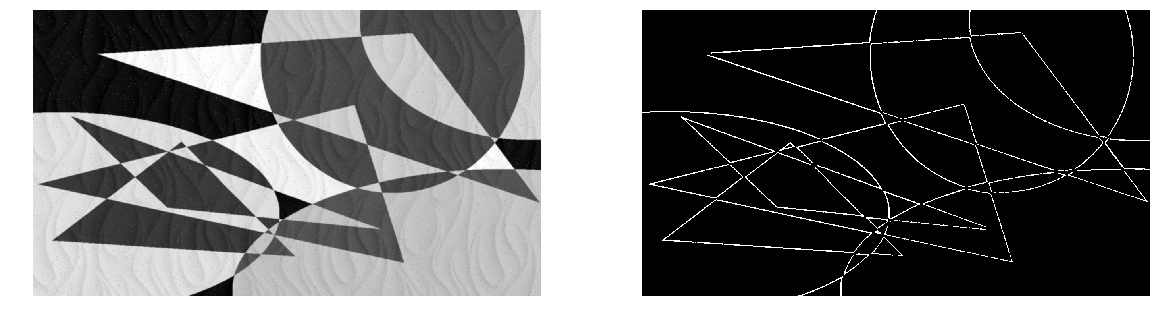

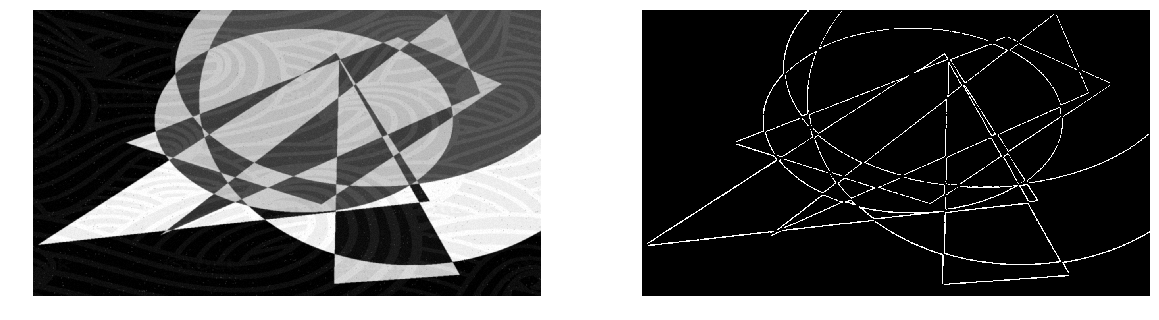

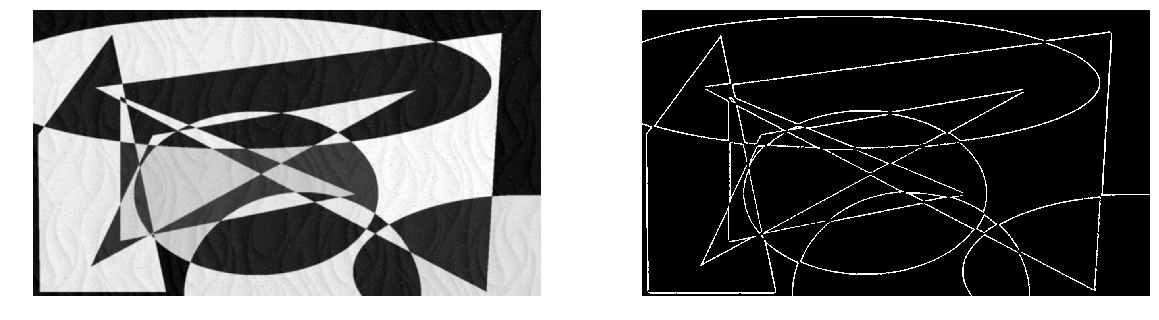

In [5]:
for im,imb in zip(ims,ims_bin):
    imshow2(im,imb)

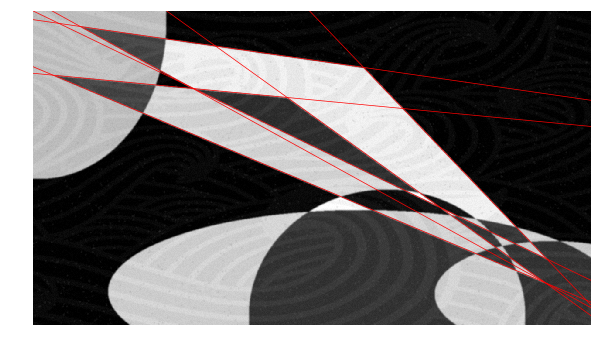

In [6]:
plot_lines(ims[0],lines[0][0],lines[0][1])

## Hough

In [4]:
%%time
dist_max = np.sqrt(ims_bin.shape[1]**2+ims_bin.shape[2]**2)
delta_angle = np.pi/(dist_max*2)
ims_hough = list()
for im in ims_bin:
    h, theta, d = hough_line(im,np.arange(-np.pi/2,np.pi/2,delta_angle))
    ims_hough.append(h.astype('uint16'))
ims_hough = np.array(ims_hough)
ims_hough[0].shape

CPU times: user 24.5 s, sys: 1.28 s, total: 25.8 s
Wall time: 25.8 s


In [8]:
ims_hough.shape

(10, 2938, 2938)

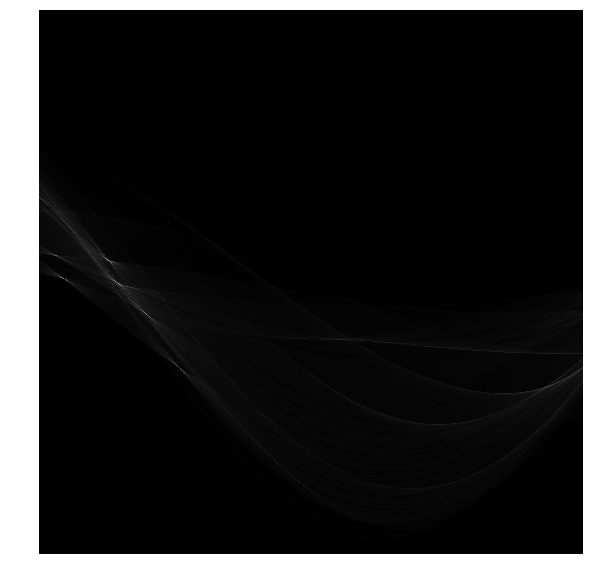

In [9]:
imshow(ims_hough[0])

## Skimage Peaks

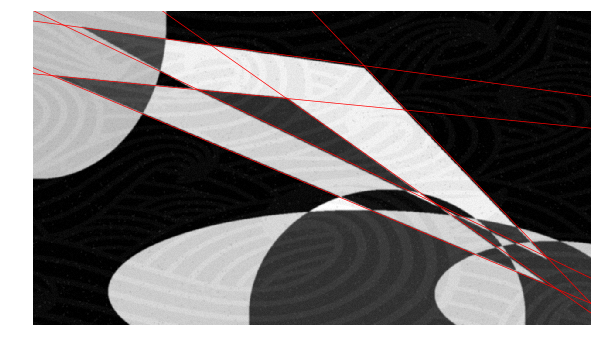

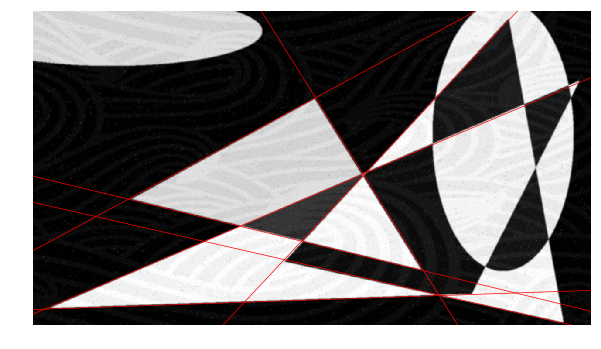

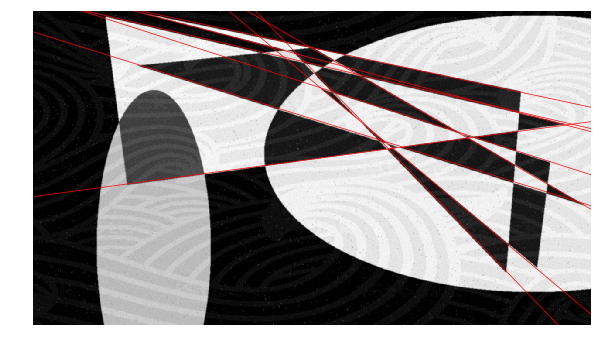

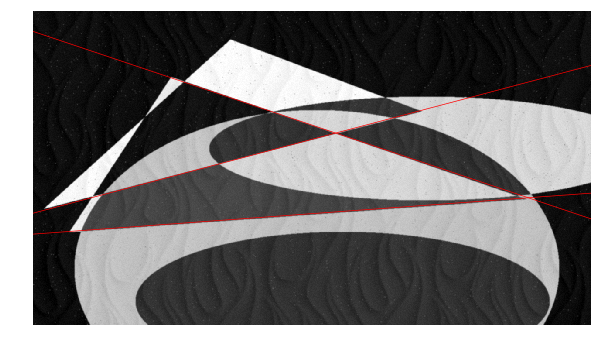

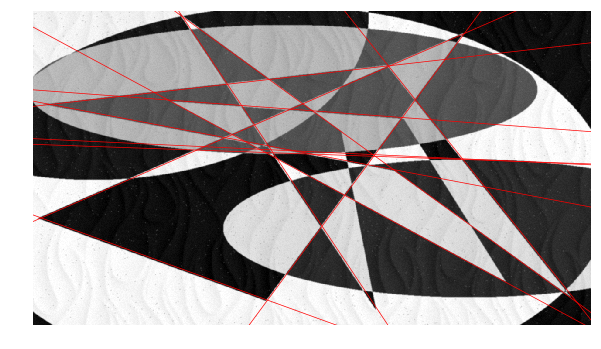

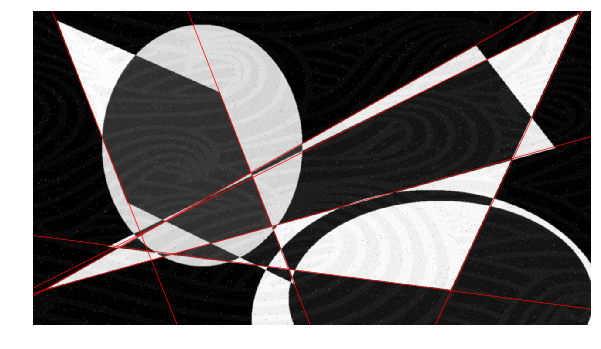

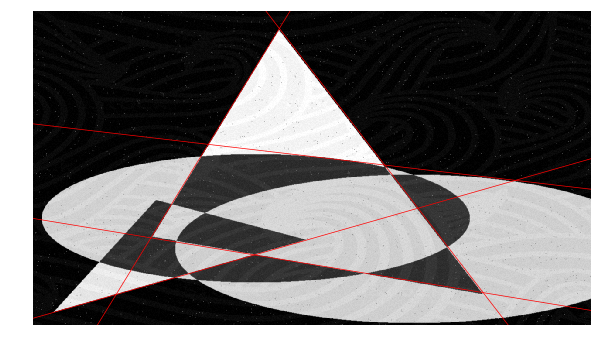

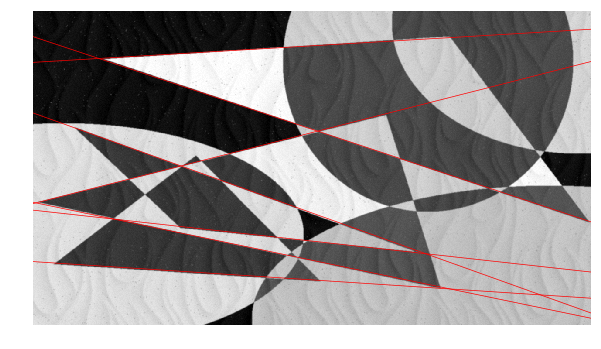

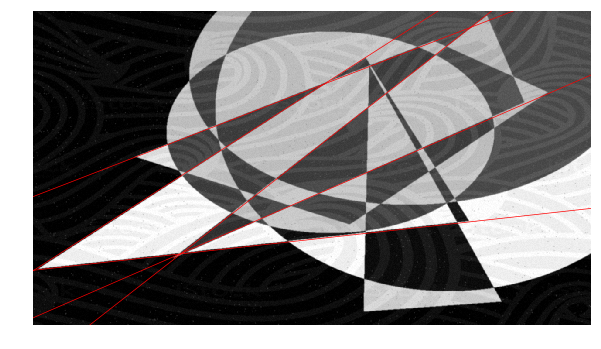

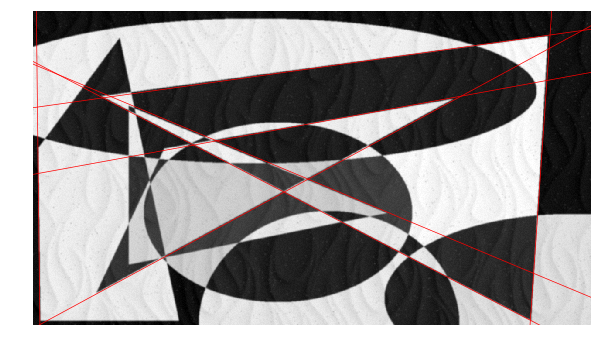

CPU times: user 7.86 s, sys: 2.15 s, total: 10 s
Wall time: 8.15 s


In [10]:
%%time
for im_h,im in zip(ims_hough, ims):
    _, angles, dists = hough_line_peaks(im_h,  theta, d)
    plot_lines(im,dists,np.pi/2-angles)

## Hough mask

In [5]:
max_dist = np.sqrt(ims.shape[1]**2+ims.shape[2]**2)
masks = np.zeros(ims_hough.shape,dtype ='uint8')

for i in range(len(lines)):
    
    dists = lines[i][0].copy()
    angles = lines[i][1].copy()
    
    #dist to pixels
    dists = dists+max_dist
    dists[angles<0] = 2*max_dist-dists[angles<0]
    ys = np.round(dists).astype('int')
    
    #angle to pixels
    angles[angles>0] = np.pi-angles[angles>0]
    angles = np.abs(angles)
    xs = np.round(angles/delta_angle).astype('int')

    masks[i,ys,xs] = 1
    
    #dilate
    #kernel = np.ones((3,3),np.uint8)
    #masks[i] = cv2.dilate(masks[i],kernel,iterations = 1)

## Expand to convolution

In [6]:
patche_size = 17

In [7]:
def expand(ims,patche_size):
    
    p = int((patche_size-1)/2)
    new_ims = list()

    for im in ims:
        
        new_im = np.zeros(np.array(im.shape)+p*2)
        new_im = new_im.astype(type(im[0,0]))
        
        #center
        new_im[p:-p,p:-p] = im
        
        #border
        new_im[p:-p,:p] = im[::-1,-p:]
        new_im[p:-p,-p:]= im[::-1,:p]
        
        #save
        new_ims.append(new_im)

    #to numpy
    new_ims = np.array(new_ims,dtype = type(ims[0,0,0]))
    return new_ims

In [8]:
def contract(ims,patche_size):
    p = int((patche_size-1)/2)
    #cut
    new_ims = [im[p:-p,p:-p] for im in ims]
    #to numpy
    new_ims = np.array(new_ims,dtype = type(ims[0,0,0]))
    return new_ims

In [9]:
print(ims_hough.shape,masks.shape)
ims_hough = expand(ims_hough,patche_size)
masks = expand(masks,patche_size)
print(ims_hough.shape,masks.shape)

(50, 2938, 2938) (50, 2938, 2938)
(50, 2954, 2954) (50, 2954, 2954)


## Cut border

In [10]:
def cut_border(ims, masks = None):
    new_ims = list()
    if masks is None:#only ims
        for im in ims:
            #cut
            new_ims.append(im[~np.all(im == 0, axis=1)].astype(type(ims[0,0,0])))
        return np.array(new_ims)
    else:            #ims and masks
        new_masks = list()
        for im,mask in zip(ims,masks):
            #cut
            new_masks.append(mask[~np.all(im == 0, axis=1)].astype(type(masks[0,0,0])))
            new_ims.append(im[~np.all(im == 0, axis=1)].astype(type(ims[0,0,0])))
        #to numpy
        new_ims = np.array(new_ims)
        new_masks = np.array(new_masks)
        
        return new_ims,new_masks

In [11]:
%%time
ims_hough,masks = cut_border(ims_hough,masks)

CPU times: user 714 ms, sys: 308 ms, total: 1.02 s
Wall time: 1.02 s


## Plot

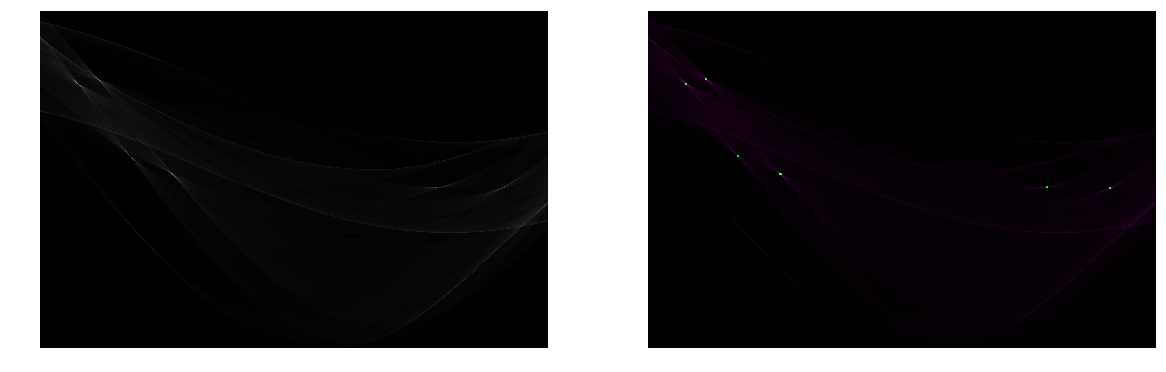

In [12]:
#dilate mask
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(masks[0],kernel,iterations = 3)
# to gray [0,1)
im_gray = ims_hough[0].astype('float32')/ims_hough[0].max()
# to rgb
im_rgb = cv2.cvtColor(im_gray,cv2.COLOR_GRAY2RGB)
#show
im_pts = im_rgb.copy()
im_pts[:,:,1] = dilation
imshow2(im_rgb,im_pts)

## Save mask points

In [13]:
def save_masks_points(masks, patche_size=17):
    #half
    p = int((patche_size-1)/2) 
    
    pts = list()
    for mask in masks:
        #find central points
        ys,xs = np.where(mask[p:-p,p:-p])
        #save
        pts.append([ys.astype('uint16'),xs.astype('uint16')])

    return np.array(pts)

In [14]:
pts = save_masks_points(masks)
pts.shape

(50, 2)

## Save

In [15]:
SAVE_PATCHES = False
min_pixels = 200
prob_to_save = 1e-4

In [16]:
%%time
#save the images
k = 0
name = 'train' #test
for im_h,mask in zip(ims_hough,masks):
    k+=1
    np.save('data/'+name+'/im_'+str(k),im_h)
    np.save('data/'+name+'/label_'+str(k),mask)

CPU times: user 294 ms, sys: 351 ms, total: 645 ms
Wall time: 8.8 s


In [17]:
try:#load
    pts_ant = np.load('data/'+name+'/points.npy')
    pts = np.concatenate((pts_ant, pts), axis=0)
except:
    None
#save the points
np.save('data/'+name+'/points',pts)
pts.shape

(100, 2)

__patches:__

In [23]:
%%time
#save the patches
if SAVE_PATCHES:
    #variables
    half = int(patche_size/2)
    shape = ims_hough[0].shape
    k = 0

    for im_h,mask in zip(ims_hough,masks):
        #print
        k+=1
        print(k,'/',masks.shape[0], end = '')

        patches = list()
        Y = list()
        #for pixel
        for i in range(half,shape[0]-half):#rows
            for j in range(half,shape[1]-half):#cols
                #cut
                im = im_h[ i-half:i+half+1 , j-half:j+half+1 ]

                prob =np.random.random()
                # so weak
                if not mask[i,j] and \
                    ((im.sum() < min_pixels) or \
                    (prob_to_save < prob)):
                    continue 
                #save
                patches.append(im)
                Y.append(mask[i,j])


        patches = np.array(patches)
        Y = np.array(Y)

        #save
        print('  data/patches/patches'+str(k)+'.npy')
        np.save('data/patches/patches'+str(k),patches)
        np.save('data/patches/Y'+str(k),Y)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


## Data generator